# Clustering Assignment

**Objective:** To identify the countries which are in direst need of funds and suggest them to the HELP international (an international humanitarian NGO), by analysing the socio-economic and health factors of the countries in the world.

In [1]:
# Suppressing the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='dark')
import altair as alt
import plotly as py
import plotly.graph_objs as go

# Libraries for rescaling and k-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Libraries for hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Settings for pandas data display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:,.4f}'.format)

## Reading and understanding the data

In [3]:
# Reading the dataset
country = pd.read_csv('Country-data.csv')
country.head()

country  child_mort  exports  health  imports  income  \
0  Afghanistan         90.2000     10.0000  7.5800  44.9000   1610     
1  Albania             16.6000     28.0000  6.5500  48.6000   9930     
2  Algeria             27.3000     38.4000  4.1700  31.4000   12900    
3  Angola              119.0000    62.3000  2.8500  42.9000   5900     
4  Antigua and Barbuda 10.3000     45.5000  6.0300  58.9000   19100    

   inflation  life_expec  total_fer   gdpp  
0 9.4400     56.2000     5.8200      553    
1 4.4900     76.3000     1.6500      4090   
2 16.1000    76.5000     2.8900      4460   
3 22.4000    60.1000     6.1600      3530   
4 1.4400     76.8000     2.1300      12200

In [4]:
# Reading the data dictionary
data_dict = pd.read_csv('data-dictionary+.csv')
data_dict

Column Name  \
0  country      
1  child_mort   
2  exports      
3  health       
4  imports      
5  Income       
6  Inflation    
7  life_expec   
8  total_fer    
9  gdpp         

                                                                                                        Description  
0  Name of the country                                                                                               
1  Death of children under 5 years of age per 1000 live births                                                       
2  Exports of goods and services per capita. Given as %age of the GDP per capita                                     
3  Total health spending per capita. Given as %age of GDP per capita                                                 
4  Imports of goods and services per capita. Given as %age of the GDP per capita                                     
5  Net income per person                                                                                             
6  The measurement of the annual growth rate of the Total GDP                                                        
7  The average number of years a new born child would live if the current mortality patterns are to remain the same  
8  The number of children that would be born to each woman if the current age-fertility rates remain the same.       
9  The GDP per capita. Calculated as the Total GDP divided by the total population.

In [5]:
# Finding the shape of the dataset
country.shape

(167, 10)

We can see that our dataset consists of **10 columns and 167 rows.**

In [6]:
# Finding the name of columns present
country.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [7]:
# Finding the general info about our dataset
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [8]:
# Finding the number of null values in the dataset 
country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

There are **no null values** present in our dataset.

In [9]:
# Finding the number of unique values for each variable
country.nunique()

country       167
child_mort    139
exports       147
health        147
imports       151
income        156
inflation     156
life_expec    127
total_fer     138
gdpp          157
dtype: int64

In [10]:
# Finding the datatypes present in the dataset
country.dtypes

country       object 
child_mort    float64
exports       float64
health        float64
imports       float64
income        int64  
inflation     float64
life_expec    float64
total_fer     float64
gdpp          int64  
dtype: object

All the columns, except the `country` column are of numerical type.

From the data dictionary, we can see that the variables `exports`, `imports` and `health` are given as the percentage of `gdpp`. Hence, we'll change these variables to their absolute values.

In [11]:
# Finding the absolute value of the variables
country['exports'] = country['exports']*country['gdpp']/100
country['imports'] = country['imports']*country['gdpp']/100
country['health'] = country['health']*country['gdpp']/100
country.head()

country  child_mort    exports   health    imports  income  \
0  Afghanistan         90.2000     55.3000    41.9174  248.2970    1610     
1  Albania             16.6000     1,145.2000 267.8950 1,987.7400  9930     
2  Algeria             27.3000     1,712.6400 185.9820 1,400.4400  12900    
3  Angola              119.0000    2,199.1900 100.6050 1,514.3700  5900     
4  Antigua and Barbuda 10.3000     5,551.0000 735.6600 7,185.8000  19100    

   inflation  life_expec  total_fer   gdpp  
0 9.4400     56.2000     5.8200      553    
1 4.4900     76.3000     1.6500      4090   
2 16.1000    76.5000     2.8900      4460   
3 22.4000    60.1000     6.1600      3530   
4 1.4400     76.8000     2.1300      12200

In [12]:
# Finding the attributes of numerical variables
country.describe()

child_mort      exports     health      imports       income  \
count 167.0000    167.0000     167.0000   167.0000     167.0000       
mean  38.2701     7,420.6188   1,056.7332 6,588.3521   17,144.6886    
std   40.3289     17,973.8858  1,801.4089 14,710.8104  19,278.0677    
min   2.6000      1.0769       12.8212    0.6511       609.0000       
25%   8.2500      447.1400     78.5355    640.2150     3,355.0000     
50%   19.3000     1,777.4400   321.8860   2,045.5800   9,960.0000     
75%   62.1000     7,278.0000   976.9400   7,719.6000   22,800.0000    
max   208.0000    183,750.0000 8,663.6000 149,100.0000 125,000.0000   

       inflation  life_expec  total_fer         gdpp  
count 167.0000   167.0000    167.0000   167.0000      
mean  7.7818     70.5557     2.9480     12,964.1557   
std   10.5707    8.8932      1.5138     18,328.7048   
min   -4.2100    32.1000     1.1500     231.0000      
25%   1.8100     65.3000     1.7950     1,330.0000    
50%   5.3900     73.1000     2.4100     4,660.0000    
75%   10.7500    76.8000     3.8800     14,050.0000   
max   104.0000   82.8000     7.4900     105,000.0000

In [13]:
# Checking if duplicates are present in our data
sum(country.duplicated(subset='country'))

0

From this, we can that there are **no duplicate values** present.

## Data Visualisation

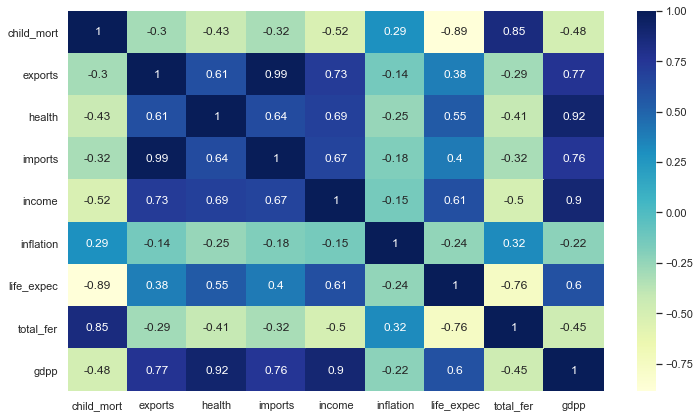

In [14]:
# We'll first find the correlation between the numerical variables in our data
plt.figure(figsize=(12,7))
sns.heatmap(country.corr(), annot=True, cmap='YlGnBu')
plt.show()

- We can see that some of the variables like `health`, `imports`, `exports`, `income` are highly correlated with `gdpp` as there derived from this variable.
- `total_fer` and `child_mort` are highly correlated at 0.85, showing us that higher fertility rate and higher child mortality are interlinked with each other.
- The total health spending (`health`) is inversely correlated with `child_mort` and `total_fer` and is directly correlated with the `life_expec`.

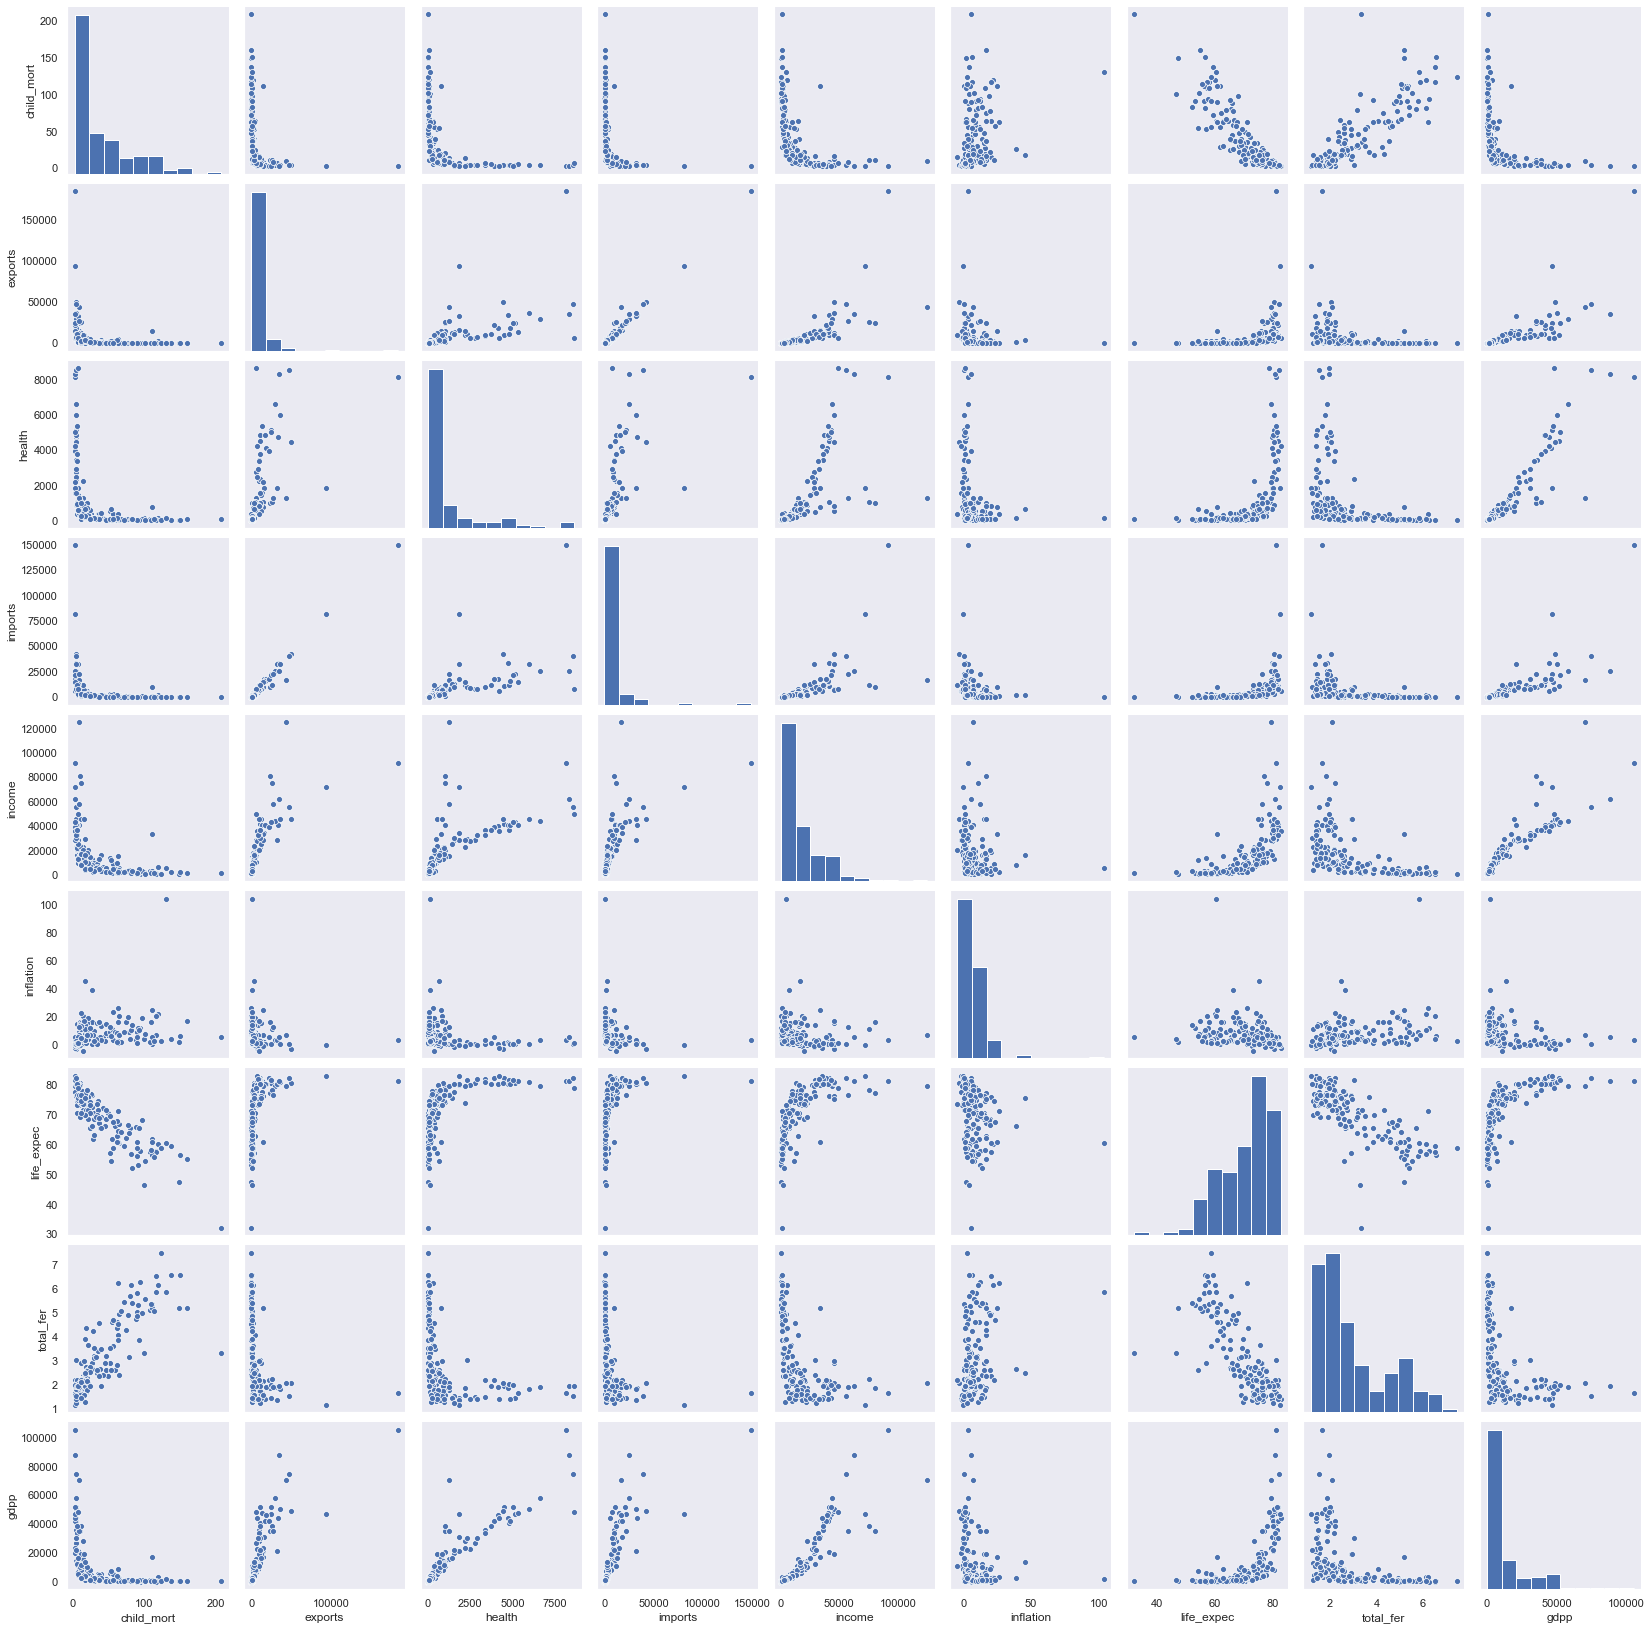

In [15]:
# Visualising the bivariate relationship between the numerical variables
sns.pairplot(country);

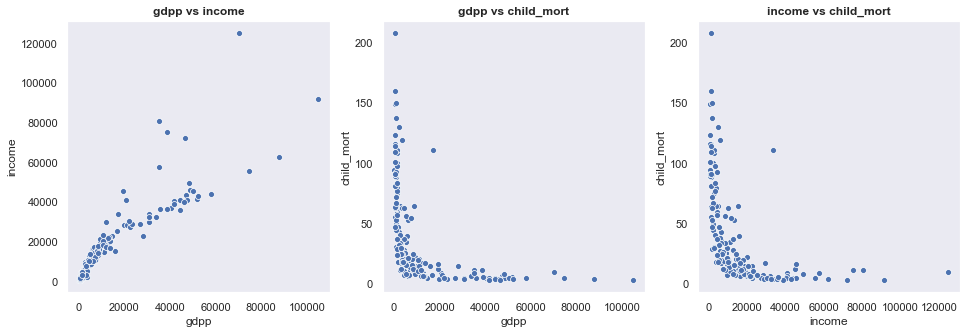

In [16]:
# Visualising bivariate relationship between 'gdpp', 'income', 'child_mort'
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.scatterplot(x='gdpp', y='income', data=country)
plt.title('gdpp vs income', fontweight='bold')
plt.subplot(132)
sns.scatterplot(x='gdpp', y='child_mort', data=country)
plt.title('gdpp vs child_mort', fontweight='bold')
plt.subplot(133)
sns.scatterplot(x='income', y='child_mort', data=country)
plt.title('income vs child_mort', fontweight='bold')
plt.subplots_adjust(wspace=0.2)
plt.show()

From the above scatterplots, we can see that,
- There's almost linear relationship between `gdpp` and `income`.
- There's inverse relationship between `child_mort` and both the variables `gdpp` and `income`, which shows that our target countries are the countries which are having low `gdpp`, low `income` and high `child_mort` among the other countries.
- We need to perform clustering to identify what all countries fall under our consideration.

We'll now see the **worst performing countries** with regards to each and every variable.

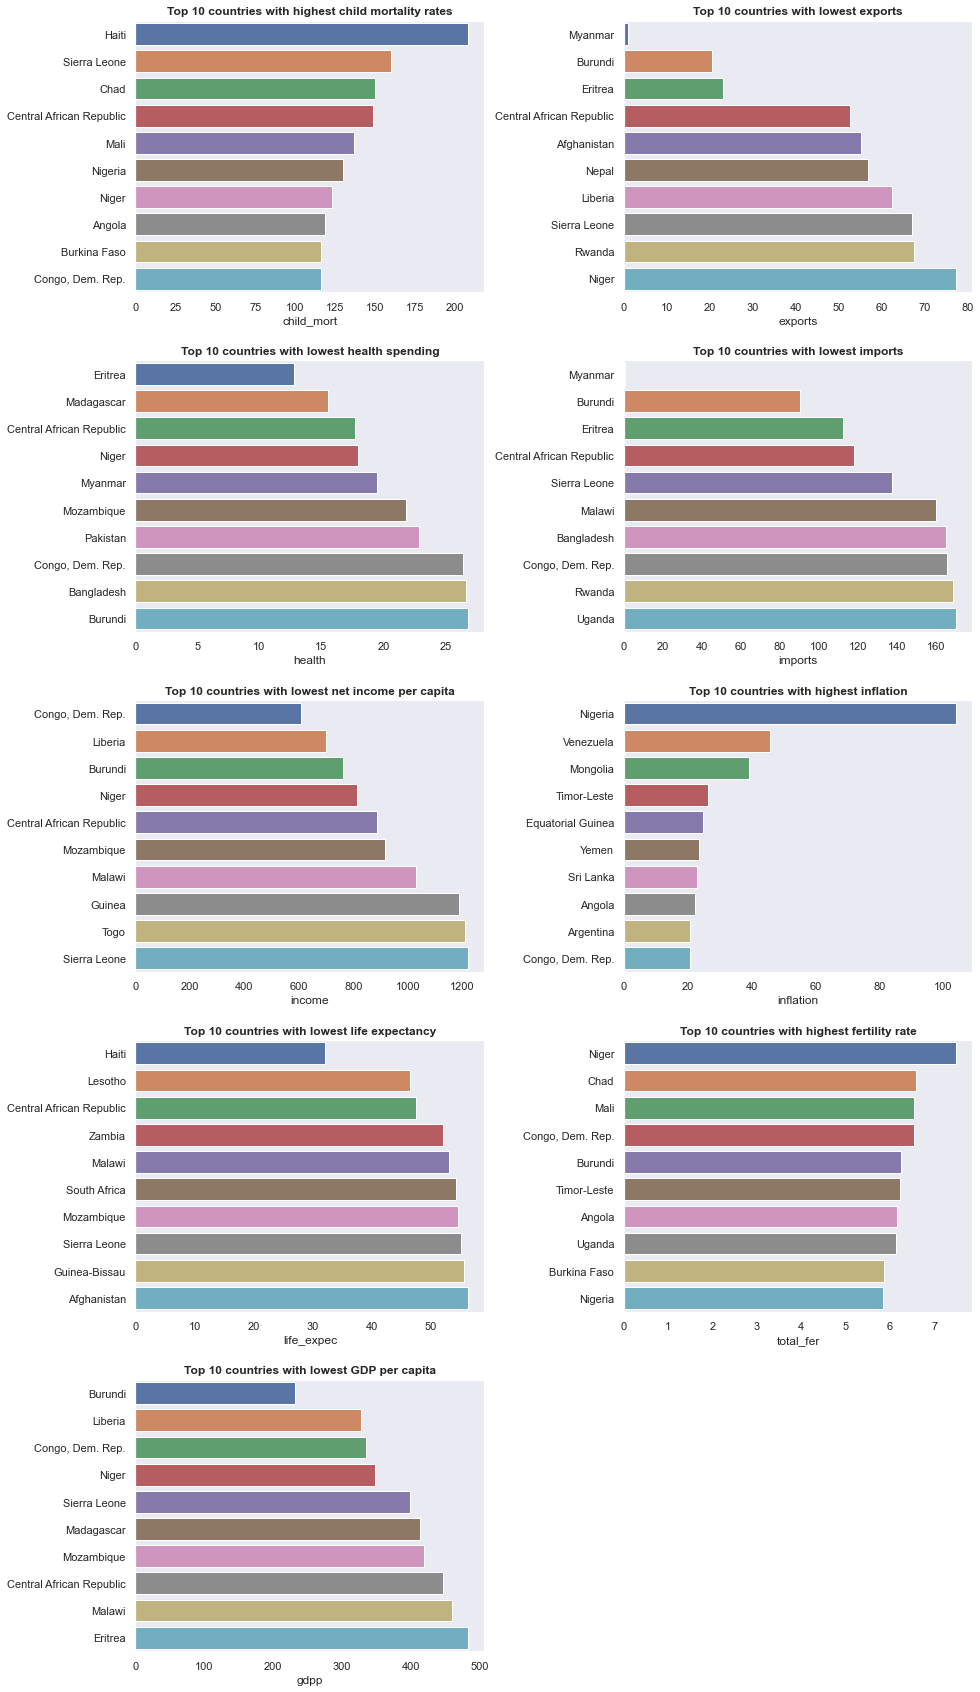

In [17]:
# Plotting barplots to compare the performance of top 10 countries in each category
cols = country.select_dtypes(exclude='object').columns
col_names = ['child mortality rates', 'exports', 'health spending', 'imports', 'net income per capita',
            'inflation', 'life expectancy', 'fertility rate', 'GDP per capita']
plt.figure(figsize = (15,30))

for i,col in enumerate(cols):
    plt.subplot(5, 2, i+1)
    if col in ['child_mort', 'inflation', 'total_fer']:
        sns.barplot(data=country.nlargest(10, col), x=col, y='country')
        plt.title('Top 10 countries with highest %s' %(col_names[i]), fontweight='bold')
        plt.ylabel(None);
    else:    
        sns.barplot(data=country.nsmallest(10, col), x=col, y='country')
        plt.title('Top 10 countries with lowest %s' %(col_names[i]), fontweight='bold')
        plt.ylabel(None);

plt.subplots_adjust(wspace=0.4, hspace = 0.25)

From the above plots, we can get the following inferences:
- <b>Child Mortality Rate:</b>
    - Haiti has the highest child mortality rate followed by Sierra Leone and Chad.
    - 9/10 countries with higest child mortality are from African continent.
- <b>Exports:</b>
    - Myanmar does dispropotionately low amount of exports.
    - 7/10 countries are from Africa and the remaining 3 are from Asia.
- <b>Total Health Spending:</b>
    - Eritrea spends the least towards health.
    - Here also, 7/10 are from Africa and the remaining 3 are from Asia.
- <b>Imports:</b>
    - Myanmar does the least amount of imports as like in the case of exports.
    - 5/10 which does lowest exports are also there in this list.
- <b>Income per capita:</b>
    - Congo, Dem. Rep. has the lowest income per capita.
    - Here, 10/10 countries are from Africa.
- <b>Inflation:</b>
    - Nigeria has dispropotionately high inflation rate followed by Venezuela and Mongolia at a significant distance.
- <b>Life Expectancy:</b>
    - Haiti has the lowest life expectancy.
    - 8/10 countries which have lowest life expectancy are from Africa.
- <b>Fertility Rate:</b>
    - All the top 10 countries with highest fertility rates are from Africa and they have a fertility rate of around 6.
- <b>GDP per capita:</b>
    - Burundi has the lowest per capita GDP.
    - 10/10 countries are from Africa.

By analysing the above socio-economic and health factors of the countries, we can get a rough idea that our target countries would mostly be present in African continent.

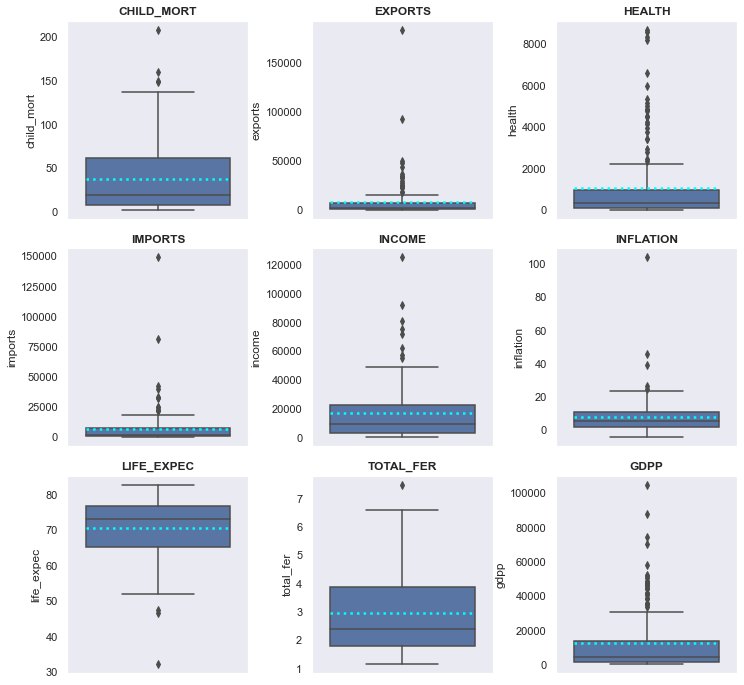

In [18]:
# Visualising the univariate distribution of the variables
cols = country.select_dtypes(exclude='object').columns
plt.figure(figsize = (12,12))
meanlineprops = {'linestyle':'dotted', 'linewidth':2.5, 'color':'cyan'}

for i,col in enumerate(cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=col, data=country, showmeans=True, meanline=True, meanprops=meanlineprops)
    plt.title(col.upper(), weight='bold')

plt.subplots_adjust(wspace=0.35, hspace = 0.15)

<i>The mean is marked by light blue dotted line.</i>

From the above boxplots, we can see that outliers present in our data. As clustering can be influenced by the presence of outliers in the data, we'll treat the outliers to get the optimal output from clustering. 

## Data Preparation

### Outlier treatment

Here, as our data is small and as we need to analyse all the countries to find the target countries from the lot, we cannot remove the outliers. So, we can cap the outliers.

In [19]:
country.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

child_mort      exports     health      imports       income  \
count 167.0000    167.0000     167.0000   167.0000     167.0000       
mean  38.2701     7,420.6188   1,056.7332 6,588.3521   17,144.6886    
std   40.3289     17,973.8858  1,801.4089 14,710.8104  19,278.0677    
min   2.6000      1.0769       12.8212    0.6511       609.0000       
1%    2.8000      22.2437      17.0094    104.9096     742.2400       
5%    3.4600      70.4688      26.7159    169.2810     1,213.0000     
10%   4.2000      110.2248     36.5026    211.0056     1,524.0000     
25%   8.2500      447.1400     78.5355    640.2150     3,355.0000     
50%   19.3000     1,777.4400   321.8860   2,045.5800   9,960.0000     
75%   62.1000     7,278.0000   976.9400   7,719.6000   22,800.0000    
90%   100.2200    17,760.6000  3,825.4160 15,034.2800  41,220.0000    
95%   116.0000    31,385.1000  4,966.7010 24,241.5600  48,290.0000    
99%   153.4000    64,794.2600  8,410.3304 55,371.3900  84,374.0000    
max   208.0000    183,750.0000 8,663.6000 149,100.0000 125,000.0000   

       inflation  life_expec  total_fer         gdpp  
count 167.0000   167.0000    167.0000   167.0000      
mean  7.7818     70.5557     2.9480     12,964.1557   
std   10.5707    8.8932      1.5138     18,328.7048   
min   -4.2100    32.1000     1.1500     231.0000      
1%    -2.3488    47.1600     1.2432     331.6200      
5%    0.1834     55.7800     1.3900     465.9000      
10%   0.5878     57.8200     1.4520     593.8000      
25%   1.8100     65.3000     1.7950     1,330.0000    
50%   5.3900     73.1000     2.4100     4,660.0000    
75%   10.7500    76.8000     3.8800     14,050.0000   
90%   16.6400    80.4000     5.3220     41,840.0000   
95%   20.8700    81.4000     5.8610     48,610.0000   
99%   41.4780    82.3700     6.5636     79,088.0000   
max   104.0000   82.8000     7.4900     105,000.0000

As we can see most of the outliers are present in the upper limit and there are no visible outliers in the lower part, we'll cap all the variables at their 95th percentile. (*except in the case of* `life_expec`, *which we'll treat seperately*)

In [20]:
# Capping only the upper outliers at 95th percentile for all the variables
cols = country.select_dtypes(exclude='object').columns

for col in cols:
    Q = country[col].quantile(0.95)
    country[col] = np.where(country[col] > Q, Q, country[col])

# Capping the lower outliers in life_expec at 1st percentile
q = country['life_expec'].quantile(0.01)
country['life_expec'] = np.where(country['life_expec'] < q, q, country['life_expec'])
    
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    float64
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    float64
dtypes: float64(9), object(1)
memory usage: 13.2+ KB


In [21]:
# Checking the attributes of the numerical variables after outlier treatment
country.describe()

child_mort     exports     health     imports      income  inflation  \
count 167.0000    167.0000    167.0000   167.0000    167.0000    167.0000     
mean  36.7850     5,783.1147  954.0125   5,140.0895  15,738.7605 6.9293       
std   36.2159     8,580.0538  1,453.4266 6,696.2100  14,787.1542 6.3844       
min   2.6000      1.0769      12.8212    0.6511      609.0000    -4.2100      
25%   8.2500      447.1400    78.5355    640.2150    3,355.0000  1.8100       
50%   19.3000     1,777.4400  321.8860   2,045.5800  9,960.0000  5.3900       
75%   62.1000     7,278.0000  976.9400   7,719.6000  22,800.0000 10.7500      
max   116.0000    31,385.1000 4,966.7010 24,241.5600 48,290.0000 20.8700      

       life_expec  total_fer        gdpp  
count 167.0000    167.0000   167.0000     
mean  70.6163     2.9175     11,998.8263  
std   8.5159      1.4438     15,158.2132  
min   47.1600     1.1500     231.0000     
25%   65.3000     1.7950     1,330.0000   
50%   73.1000     2.4100     4,660.0000   
75%   76.8000     3.8800     14,050.0000  
max   81.4000     5.8610     48,610.0000

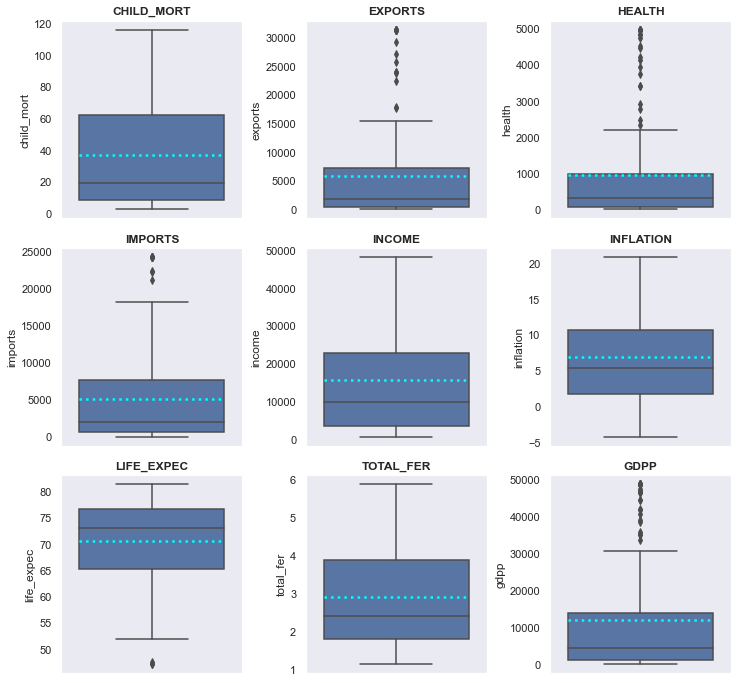

In [22]:
cols = country.select_dtypes(exclude='object').columns
plt.figure(figsize = (12,12))
meanlineprops = {'linestyle':'dotted', 'linewidth':2.5, 'color':'cyan'}

for i,col in enumerate(cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=col, data=country, showmeans=True, meanline=True, meanprops=meanlineprops)
    plt.title(col.upper(), weight='bold')

plt.subplots_adjust(wspace=0.35, hspace = 0.15)

We've capped most of the outliers which were present earlier and now we can proceed with scaling the data.

### Rescaling

In [23]:
# Dropping the 'country' column
df = country.drop('country', axis=1).copy()

In [24]:
# Instantiating the scaler
scaler = StandardScaler()

# Applying fit_transform to our dataframe(df)
df_scaled = scaler.fit_transform(df)
df_scaled.shape

(167, 9)

In [25]:
cols = df.columns

# Changing the type of the scaled data from series to dataframe
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = cols
df_scaled.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0 1.4793      -0.6696  -0.6294 -0.7327  -0.9583 0.3944     -1.6980       
1 -0.5590     -0.5422  -0.4735 -0.4722  -0.3940 -0.3832    0.6694        
2 -0.2627     -0.4758  -0.5300 -0.5602  -0.1926 1.4408     0.6930        
3 2.1939      -0.4190  -0.5889 -0.5431  -0.6674 2.1901     -1.2386       
4 -0.7335     -0.0271  -0.1507 0.3064   0.2280  -0.8624    0.7283        

   total_fer    gdpp  
0 2.0164     -0.7574  
1 -0.8805    -0.5233  
2 -0.0191    -0.4988  
3 2.0449     -0.5604  
4 -0.5471    0.0133

In [26]:
df_scaled.describe()

child_mort  exports   health  imports   income  inflation  life_expec  \
count 167.0000    167.0000 167.0000 167.0000 167.0000 167.0000   167.0000      
mean  -0.0000     -0.0000  0.0000   0.0000   0.0000   0.0000     0.0000        
std   1.0030      1.0030   1.0030   1.0030   1.0030   1.0030     1.0030        
min   -0.9468     -0.6759  -0.6495  -0.7698  -1.0262  -1.7500    -2.7627       
25%   -0.7903     -0.6238  -0.6042  -0.6740  -0.8400  -0.8043    -0.6262       
50%   -0.4843     -0.4683  -0.4362  -0.4635  -0.3920  -0.2418    0.2925        
75%   0.7011      0.1748   0.0158   0.3864   0.4790   0.6002     0.7283        
max   2.1939      2.9929   2.7692   2.8612   2.2079   2.1901     1.2701        

       total_fer     gdpp  
count 167.0000   167.0000  
mean  0.0000     0.0000    
std   1.0030     1.0030    
min   -1.2279    -0.7787   
25%   -0.7798    -0.7059   
50%   -0.3526    -0.4856   
75%   0.6687     0.1357    
max   2.0449     2.4225

### Hopkins Test
First we'll find if our data is suitable for clustering by performing the Hopkins test.

In [27]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

As Hopkins score gives out different value when executed each and every time, we'll get a average of hopkins score by running it considerably high number of times. (<i>In this case, 500 times</i>)

In [28]:
hopkins_scores = []
i = 0
while i < 500: 
    hopkins_scores.append(hopkins(df_scaled))
    i += 1
mean_hopkins_score = sum(hopkins_scores)/len(hopkins_scores)
print(round(mean_hopkins_score,4))

0.8457


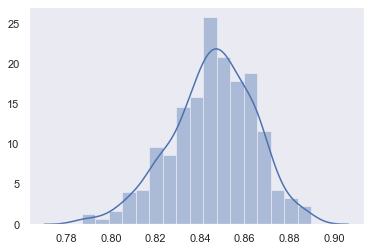

In [29]:
sns.distplot(hopkins_scores);

We have got an average Hopkins score of around 0.85, which indicates our data is suitable for clustering.

## Modelling
### K-means Clustering
#### Finding the optimal number of clusters for k-means using SSD and Silhouette score

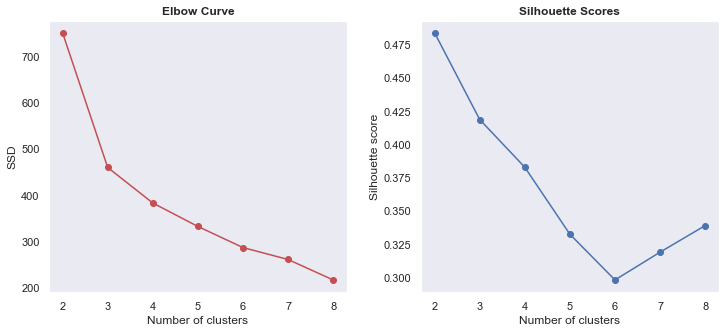

In [30]:
ssd = []
sil = []
n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
for n in n_clusters_list:
    kmeans = KMeans(n_clusters=n, max_iter=50, random_state=100)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)
    cluster_labels = kmeans.labels_
    silhouette_avg = round(silhouette_score(df_scaled, cluster_labels),4)
    sil.append([n, silhouette_avg])

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(n_clusters_list, ssd, 'ro-')
plt.title('Elbow Curve', fontsize=12, fontweight='bold')
plt.xlabel('Number of clusters')
plt.ylabel('SSD')

plt.subplot(122)
plt.plot([x[0] for x in sil], [x[1] for x in sil], 'bo-')
plt.title('Silhouette Scores', fontsize=12, fontweight='bold')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.subplots_adjust(wspace=0.25)

plt.show()

From the above graphs, we can see that
- There is an elbow when the number of clusters is 3.
- The silhouette score for the clusters formed when n=3 is around 0.42.

So, we can proceed with the number of clusters as 3 for our analysis.

In [31]:
# Initialising k-means
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=100)

# Fitting the scaled data
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3, random_state=100)

In [32]:
# Finding the labels of the clusters formed
kmeans.labels_

array([1, 2, 2, 1, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 2, 1,
       2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2,
       1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 2, 1,
       1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 1, 2, 2,
       1, 0, 0, 0, 1, 1, 0, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 1, 2, 2, 2,
       2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1])

In [33]:
# Assigning the labels to the original dataframe
df_clusters = country.copy()
df_clusters['cluster_id'] = kmeans.labels_
df_clusters.head()

country  child_mort    exports   health    imports      income  \
0  Afghanistan         90.2000     55.3000    41.9174  248.2970   1,610.0000    
1  Albania             16.6000     1,145.2000 267.8950 1,987.7400 9,930.0000    
2  Algeria             27.3000     1,712.6400 185.9820 1,400.4400 12,900.0000   
3  Angola              116.0000    2,199.1900 100.6050 1,514.3700 5,900.0000    
4  Antigua and Barbuda 10.3000     5,551.0000 735.6600 7,185.8000 19,100.0000   

   inflation  life_expec  total_fer        gdpp  cluster_id  
0 9.4400     56.2000     5.8200     553.0000     1           
1 4.4900     76.3000     1.6500     4,090.0000   2           
2 16.1000    76.5000     2.8900     4,460.0000   2           
3 20.8700    60.1000     5.8610     3,530.0000   1           
4 1.4400     76.8000     2.1300     12,200.0000  2

In [34]:
df_clusters['cluster_id'].value_counts()

2    82
1    48
0    37
Name: cluster_id, dtype: int64

Now that we have 3 clusters formed by k-means algorithm, we can compare the countries based on their performance in `gdpp`, `child_mort` and `income`.

First we'll visualise the clusters by plotting the scatterplots between the selected variables.

### Visualisation of clusters formed by K-Means clustering

In [35]:
# Defining palette for visualisation
pal_r = sns.color_palette(['mediumseagreen','crimson','steelblue'])

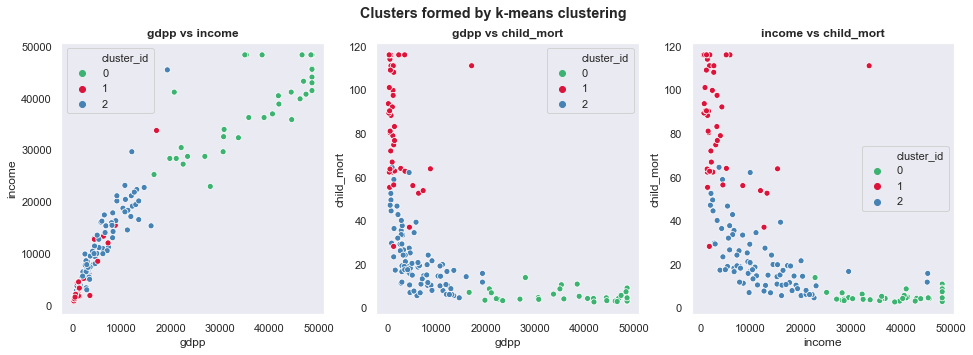

In [36]:
# Scatterplots of 'gdpp', 'income', 'child_mort'
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.scatterplot(x='gdpp', y='income', data=df_clusters, hue='cluster_id', palette=pal_r)
plt.title('gdpp vs income', fontweight='bold')
plt.subplot(132)
sns.scatterplot(x='gdpp', y='child_mort', data=df_clusters, hue='cluster_id', palette=pal_r)
plt.title('gdpp vs child_mort', fontweight='bold')
plt.subplot(133)
sns.scatterplot(x='income', y='child_mort', data=df_clusters, hue='cluster_id', palette=pal_r)
plt.title('income vs child_mort', fontweight='bold')
plt.subplots_adjust(wspace=0.2)
plt.suptitle('Clusters formed by k-means clustering', fontweight='bold')
plt.show()

From the above scatterplots, by analysing these 3 clusters we find that, 
- <b style='color:steelblue;'>cluster_id = 0</b> - high income, high gdpp, low child_mort - Developed countries
- <b style='color:crimson;'>cluster_id = 1 - low income, low gdpp, high child_mort - Under-developed countries</b>
- <b style='color:mediumseagreen;'>cluster_id = 2</b> - moderate income, moderate gdpp, moderate child_mort - Developing countries

#### Our target countries are present in the cluster with under-developed countries (cluster_id=1).

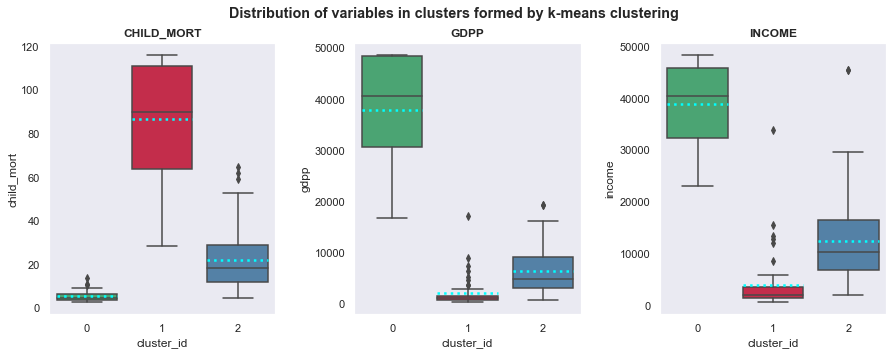

In [37]:
# Boxplots to differentiate the clusters
cols = ['child_mort', 'gdpp', 'income']
plt.figure(figsize = (15,5))
meanlineprops = {'linestyle':'dotted', 'linewidth':2.5, 'color':'cyan'}

for i,col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=col, x='cluster_id', data=df_clusters, showmeans=True, meanline=True, meanprops=meanlineprops, palette=pal_r)
    plt.title(col.upper(), weight='bold')

plt.suptitle('Distribution of variables in clusters formed by k-means clustering', fontweight='bold')
plt.subplots_adjust(wspace=0.35, hspace = 0.15)

From the above boxplots,
- **cluster_id = 0** - Lowest child mortality, Highest GDP per capita, Highest net income - Developed countries
- **cluster_id = 1** - Highest child mortality, Lowest GDP per capita, Lowest net income - <b>Under-developed countries</b>
- **cluster_id = 2** - child mortality lower than cluster_id = 1, Lower GDP per capita & Lower net income than cluster_id = 0 - Developing countries

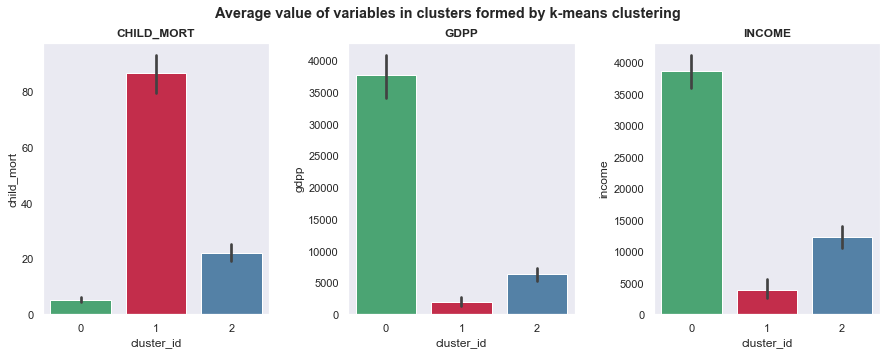

In [73]:
# Barplots to differentiate the clusters
cols = ['child_mort', 'gdpp', 'income']
plt.figure(figsize = (15,5))

for i,col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.barplot(y=col, x='cluster_id', data=df_clusters, palette=pal_r)
    plt.title(col.upper(), weight='bold')

plt.suptitle('Average value of variables in clusters formed by k-means clustering', fontweight='bold')
plt.subplots_adjust(wspace=0.35, hspace = 0.15)

From the above plots, we can see that **cluster with cluster_id as 1** has the highest average child mortality and lowest income and gdp per capita.

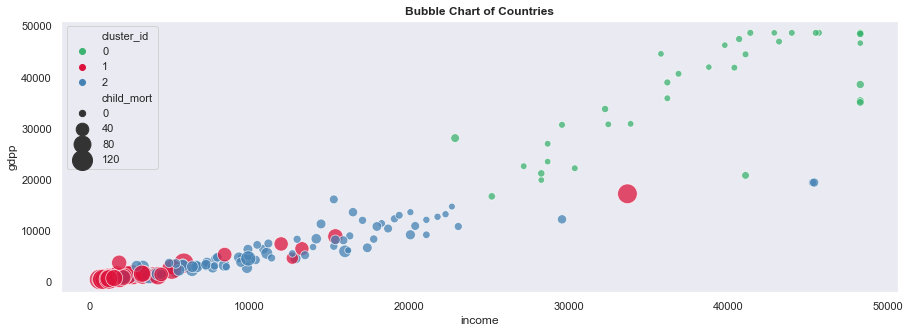

In [39]:
# Bubble chart to visualise all the 3 variables in a single chart
plt.figure(figsize=(15,5))
sns.scatterplot(x='income', y='gdpp', size='child_mort', data=df_clusters, sizes=(40,400), hue='cluster_id', 
                alpha=0.75, palette=pal_r);
plt.title('Bubble Chart of Countries', fontweight='bold');

In the above plot,
- The <b style="color:steelblue;">under-developed countries</b> are in the bottom-left part of the plot which are characterised generally by larger circles indicating they have higher child mortality rates as well.
- On the other hand, the <b style="color:crimson;">developed countries</b> are marked in the right-top part of the plot which are denoted by comparatively very small circles indicating the lower child mortality rate in those countries.

As we cannot see what countries are present in each cluster in the plot, we'll plot an interactive chart which shows the name of the country when we hover over the datapoint.

In [40]:
# Interactive bubble chart
source = df_clusters
alt.Chart(source).mark_circle(size=60).encode(
    x='income', 
    y='gdpp', 
    size='child_mort', 
    color='cluster_id:N', 
    tooltip=['country']).properties(width=800, title='Interactive Bubble Chart of Countries').interactive()

alt.Chart(...)

The cluster consists of 48 countries which are listed below.

In [41]:
target_cluster = df_clusters.loc[df_clusters.cluster_id == 1]
target_cluster

country  child_mort     exports   health     imports  \
0    Afghanistan              90.2000     55.3000     41.9174  248.2970      
3    Angola                   116.0000    2,199.1900  100.6050 1,514.3700    
17   Benin                    111.0000    180.4040    31.0780  281.9760      
21   Botswana                 52.5000     2,768.6000  527.0500 3,257.5500    
25   Burkina Faso             116.0000    110.4000    38.7550  170.2000      
26   Burundi                  93.6000     20.6052     26.7960  90.5520       
28   Cameroon                 108.0000    290.8200    67.2030  353.7000      
31   Central African Republic 116.0000    52.6280     17.7508  118.1900      
32   Chad                     116.0000    330.0960    40.6341  390.1950      
36   Comoros                  88.2000     126.8850    34.6819  397.5730      
37   Congo, Dem. Rep.         116.0000    137.2740    26.4194  165.6640      
38   Congo, Rep.              63.9000     2,331.7400  67.4040  1,498.7800    
40   Cote d'Ivoire            111.0000    617.3200    64.6600  528.2600      
49   Equatorial Guinea        111.0000    14,671.8000 766.0800 10,071.9000   
50   Eritrea                  55.2000     23.0878     12.8212  112.3060      
55   Gabon                    63.7000     5,048.7500  306.2500 1,653.7500    
56   Gambia                   80.3000     133.7560    31.9778  239.9740      
59   Ghana                    74.7000     386.4500    68.3820  601.2900      
63   Guinea                   109.0000    196.3440    31.9464  279.9360      
64   Guinea-Bissau            114.0000    81.5030     46.4950  192.5440      
66   Haiti                    116.0000    101.2860    45.7442  428.3140      
72   Iraq                     36.9000     1,773.0000  378.4500 1,534.5000    
80   Kenya                    62.2000     200.1690    45.9325  324.9120      
81   Kiribati                 62.7000     198.1700    168.3700 1,190.5100    
84   Lao                      78.9000     403.5600    50.9580  562.0200      
87   Lesotho                  99.7000     460.9800    129.8700 1,181.7000    
88   Liberia                  89.3000     62.4570     38.5860  302.8020      
93   Madagascar               62.2000     103.2500    15.5701  177.5900      
94   Malawi                   90.5000     104.6520    30.2481  160.1910      
97   Mali                     116.0000    161.4240    35.2584  248.5080      
99   Mauritania               97.4000     608.4000    52.9200  734.4000      
106  Mozambique               101.0000    131.9850    21.8299  193.5780      
108  Namibia                  56.0000     2,480.8200  351.8820 3,150.3300    
112  Niger                    116.0000    77.2560     17.9568  170.8680      
113  Nigeria                  116.0000    589.4900    118.1310 405.4200      
116  Pakistan                 92.1000     140.4000    22.8800  201.7600      
126  Rwanda                   63.6000     67.5600     59.1150  168.9000      
129  Senegal                  66.8000     249.0000    56.6000  403.0000      
132  Sierra Leone             116.0000    67.0320     52.2690  137.6550      
136  Solomon Islands          28.1000     635.9700    110.2950 1,047.4800    
137  South Africa             53.7000     2,082.0800  650.8320 1,994.7200    
142  Sudan                    76.7000     291.5600    93.5360  254.5600      
147  Tanzania                 71.9000     131.2740    42.1902  204.2820      
149  Timor-Leste              62.6000     79.2000     328.3200 1,000.8000    
150  Togo                     90.3000     196.1760    37.3320  279.6240      
155  Uganda                   81.0000     101.7450    53.6095  170.1700      
165  Yemen                    56.3000     393.0000    67.8580  450.6400      
166  Zambia                   83.1000     540.2000    85.9940  451.1400      

         income  inflation  life_expec  total_fer        gdpp  cluster_id  
0   1,610.0000  9.4400     56.2000     5.8200     553.0000     1           
3   5,900.0000  20.8700    60.1000     5.8610  

In [42]:
# Finding the description of the data
target_cluster.describe()

child_mort     exports   health     imports      income  inflation  \
count 48.0000     48.0000     48.0000  48.0000     48.0000     48.0000      
mean  86.4438     879.0635    114.8218 827.0288    3,897.3542  9.8893       
std   24.6855     2,252.4740  165.5183 1,540.9819  5,590.1686  6.8243       
min   28.1000     20.6052     12.8212  90.5520     609.0000    0.8850       
25%   63.6750     102.8738    34.0059  193.3195    1,390.0000  4.0800       
50%   89.7500     196.2600    51.6135  339.3060    1,860.0000  8.8550       
75%   111.0000    552.5225    95.3033  801.0000    3,522.5000  16.6000      
max   116.0000    14,671.8000 766.0800 10,071.9000 33,700.0000 20.8700      

       life_expec  total_fer        gdpp  cluster_id  
count 48.0000     48.0000    48.0000     48.0000      
mean  59.5671     4.8860     1,909.2083  1.0000       
std   5.2671      0.8811     2,925.9110  0.0000       
min   47.1600     2.5900     231.0000    1.0000       
25%   56.7250     4.4750     551.5000    1.0000       
50%   59.8000     5.0550     932.0000    1.0000       
75%   62.8250     5.5975     1,465.0000  1.0000       
max   71.1000     5.8610     17,100.0000 1.0000

The current cluster consists of countries with a wide range of `gdpp`, `income` and `child_mort`. So, to narrow down our analysis to find the countries which are in direst need of aid, we'll take the countries which have less `gdpp` and `income` than the group median and high `child_mort` than the group median.

In [43]:
# Subsetting our target cluster
target_cluster_final = target_cluster.loc[(target_cluster.gdpp < target_cluster.gdpp.median()) & 
                                          (target_cluster.income < target_cluster.income.median()) & 
                                          (target_cluster.child_mort > target_cluster.child_mort.median())]
target_cluster_final

country  child_mort  exports  health  imports  \
0    Afghanistan              90.2000     55.3000  41.9174 248.2970   
17   Benin                    111.0000    180.4040 31.0780 281.9760   
25   Burkina Faso             116.0000    110.4000 38.7550 170.2000   
26   Burundi                  93.6000     20.6052  26.7960 90.5520    
31   Central African Republic 116.0000    52.6280  17.7508 118.1900   
37   Congo, Dem. Rep.         116.0000    137.2740 26.4194 165.6640   
63   Guinea                   109.0000    196.3440 31.9464 279.9360   
64   Guinea-Bissau            114.0000    81.5030  46.4950 192.5440   
66   Haiti                    116.0000    101.2860 45.7442 428.3140   
94   Malawi                   90.5000     104.6520 30.2481 160.1910   
106  Mozambique               101.0000    131.9850 21.8299 193.5780   
112  Niger                    116.0000    77.2560  17.9568 170.8680   
132  Sierra Leone             116.0000    67.0320  52.2690 137.6550   
150  Togo                     90.3000     196.1760 37.3320 279.6240   

        income  inflation  life_expec  total_fer     gdpp  cluster_id  
0   1,610.0000 9.4400     56.2000     5.8200     553.0000  1           
17  1,820.0000 0.8850     61.8000     5.3600     758.0000  1           
25  1,430.0000 6.8100     57.9000     5.8610     575.0000  1           
26  764.0000   12.3000    57.7000     5.8610     231.0000  1           
31  888.0000   2.0100     47.5000     5.2100     446.0000  1           
37  609.0000   20.8000    57.5000     5.8610     334.0000  1           
63  1,190.0000 16.1000    58.0000     5.3400     648.0000  1           
64  1,390.0000 2.9700     55.6000     5.0500     547.0000  1           
66  1,500.0000 5.4500     47.1600     3.3300     662.0000  1           
94  1,030.0000 12.1000    53.1000     5.3100     459.0000  1           
106 918.0000   7.6400     54.5000     5.5600     419.0000  1           
112 814.0000   2.5500     58.8000     5.8610     348.0000  1           
132 1,220.0000 17.2000    55.0000     5.2000     399.0000  1           
150 1,210.0000 1.1800     58.7000     4.8700     488.0000  1

In [44]:
# Finding the description of variables after subsetting
target_cluster_final.describe()

child_mort  exports  health  imports     income  inflation  life_expec  \
count 14.0000     14.0000  14.0000 14.0000  14.0000    14.0000    14.0000       
mean  106.8286    108.0604 33.3241 208.3992 1,170.9286 8.3882     55.6757       
std   11.1062     54.8586  10.8257 87.7400  352.3994   6.4773     4.1352        
min   90.2000     20.6052  17.7508 90.5520  609.0000   0.8850     47.1600       
25%   95.4500     69.5880  26.5136 161.5592 895.5000   2.6550     54.6250       
50%   112.5000    102.9690 31.5122 181.7060 1,200.0000 7.2250     56.8500       
75%   116.0000    135.9518 41.1268 271.7922 1,420.0000 12.2500    57.9750       
max   116.0000    196.3440 52.2690 428.3140 1,820.0000 20.8000    61.8000       

       total_fer     gdpp  cluster_id  
count 14.0000    14.0000  14.0000      
mean  5.3210     490.5000 1.0000       
std   0.6646     143.7454 0.0000       
min   3.3300     231.0000 1.0000       
25%   5.2025     404.0000 1.0000       
50%   5.3500     473.5000 1.0000       
75%   5.8507     569.5000 1.0000       
max   5.8610     758.0000 1.0000

There are 14 countries in our final consideration.

In [45]:
print('The list of countries identified by kmeans clustering:',*list(target_cluster_final.country), sep='\n')

The list of countries identified by kmeans clustering:
Afghanistan
Benin
Burkina Faso
Burundi
Central African Republic
Congo, Dem. Rep.
Guinea
Guinea-Bissau
Haiti
Malawi
Mozambique
Niger
Sierra Leone
Togo


### Hierarchical Clustering

#### Single Linkage

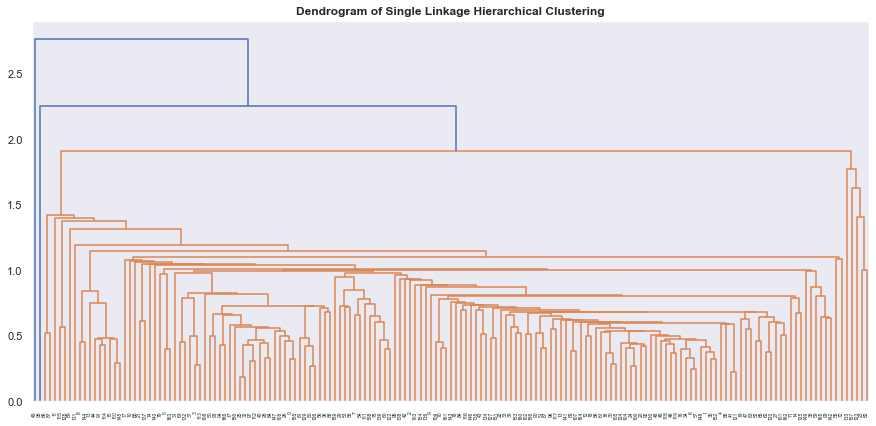

In [71]:
single_mergings = linkage(df_scaled, method='single', metric='euclidean')
plt.figure(figsize=(15,7))
dendrogram(single_mergings)
plt.title('Dendrogram of Single Linkage Hierarchical Clustering', fontweight='bold')
plt.show()

We are not able to form meaningful clusters using the single linkage, hence we'll try forming clusters using complete linkage.

#### Complete Linkage

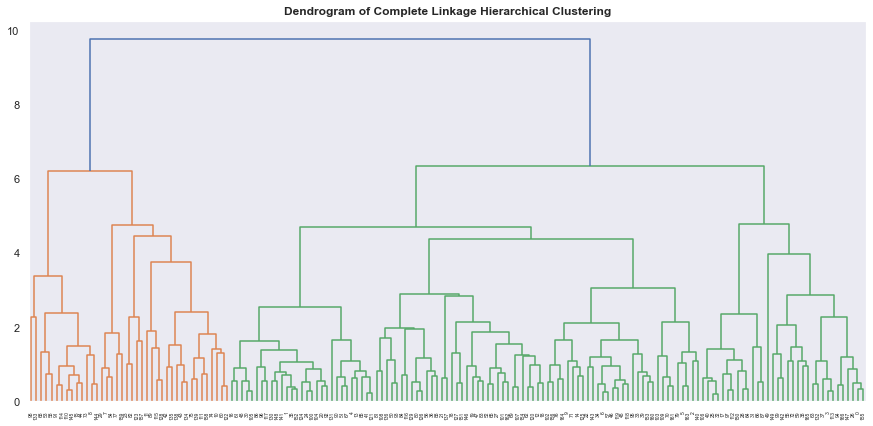

In [70]:
complete_mergings = linkage(df_scaled, method='complete', metric='euclidean')
plt.figure(figsize=(15,7))
dendrogram(complete_mergings)
plt.title('Dendrogram of Complete Linkage Hierarchical Clustering', fontweight='bold')
plt.show()

From the above dendrogram, we can see there are generally 4 clusters which are formed at a height of about 6. So, we will consider 4 as the number of clusters for our analysis.

In [48]:
# Cutting the complete_mergings into 3 clusters
cluster_labels = cut_tree(complete_mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2,
       3, 1, 1, 1, 1, 0, 1, 1, 1, 3, 2, 0, 1, 1, 3, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 3, 1, 1, 1, 0, 3, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       1, 2, 1, 3, 1, 1, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       3, 2, 0, 0, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 3, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 3, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [49]:
# Adding the labels to the original dataframe
df_hclusters = country.copy()
df_hclusters['cluster_id'] = cluster_labels
df_hclusters.head()

country  child_mort    exports   health    imports      income  \
0  Afghanistan         90.2000     55.3000    41.9174  248.2970   1,610.0000    
1  Albania             16.6000     1,145.2000 267.8950 1,987.7400 9,930.0000    
2  Algeria             27.3000     1,712.6400 185.9820 1,400.4400 12,900.0000   
3  Angola              116.0000    2,199.1900 100.6050 1,514.3700 5,900.0000    
4  Antigua and Barbuda 10.3000     5,551.0000 735.6600 7,185.8000 19,100.0000   

   inflation  life_expec  total_fer        gdpp  cluster_id  
0 9.4400     56.2000     5.8200     553.0000     0           
1 4.4900     76.3000     1.6500     4,090.0000   1           
2 16.1000    76.5000     2.8900     4,460.0000   1           
3 20.8700    60.1000     5.8610     3,530.0000   0           
4 1.4400     76.8000     2.1300     12,200.0000  1

In [50]:
df_hclusters['cluster_id'].value_counts()

1    94
0    33
2    26
3    14
Name: cluster_id, dtype: int64

We'll perform the same set of visualisations performed for clusters formed by k-means clustering.

### Visualisation of clusters formed by Hierarchical clustering

In [51]:
# Defining palette for visualisation
pal = sns.color_palette(['crimson','steelblue','mediumseagreen','orange'])

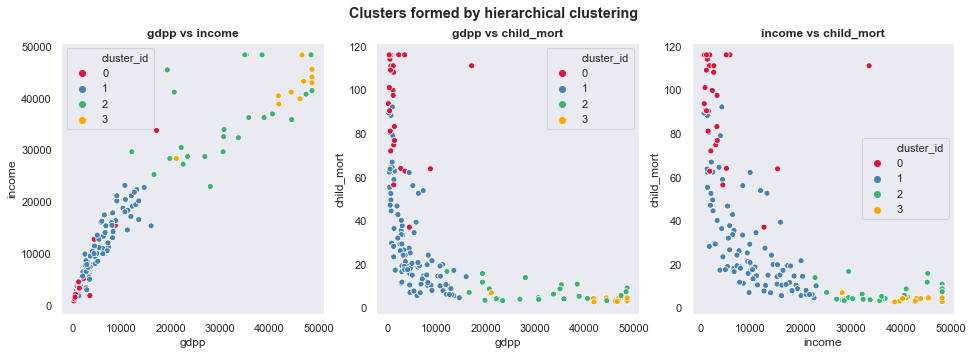

In [52]:
# Scatterplots of 'gdpp', 'income', 'child_mort'
plt.figure(figsize=(16,5))
plt.subplot(131)
sns.scatterplot(x='gdpp', y='income', data=df_hclusters, hue='cluster_id', palette=pal)
plt.title('gdpp vs income', fontweight='bold')
plt.subplot(132)
sns.scatterplot(x='gdpp', y='child_mort', data=df_hclusters, hue='cluster_id', palette=pal)
plt.title('gdpp vs child_mort', fontweight='bold')
plt.subplot(133)
sns.scatterplot(x='income', y='child_mort', data=df_hclusters, hue='cluster_id', palette=pal)
plt.title('income vs child_mort', fontweight='bold')
plt.subplots_adjust(wspace=0.2)
plt.suptitle('Clusters formed by hierarchical clustering', fontweight='bold')
plt.show()

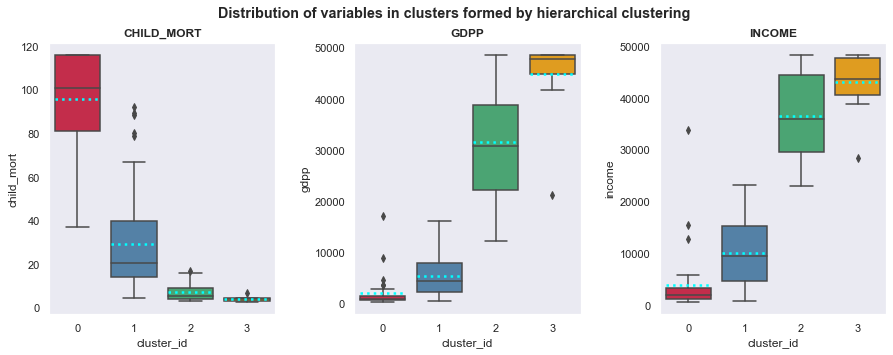

In [53]:
# Boxplots to differentiate the clusters
cols = ['child_mort', 'gdpp', 'income']
plt.figure(figsize = (15,5))
meanlineprops = {'linestyle':'dotted', 'linewidth':2.5, 'color':'cyan'}

for i,col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=col, x='cluster_id', data=df_hclusters, showmeans=True, meanline=True, meanprops=meanlineprops, palette=pal)
    plt.title(col.upper(), weight='bold')

plt.suptitle('Distribution of variables in clusters formed by hierarchical clustering', fontweight='bold')
plt.subplots_adjust(wspace=0.35, hspace = 0.15)

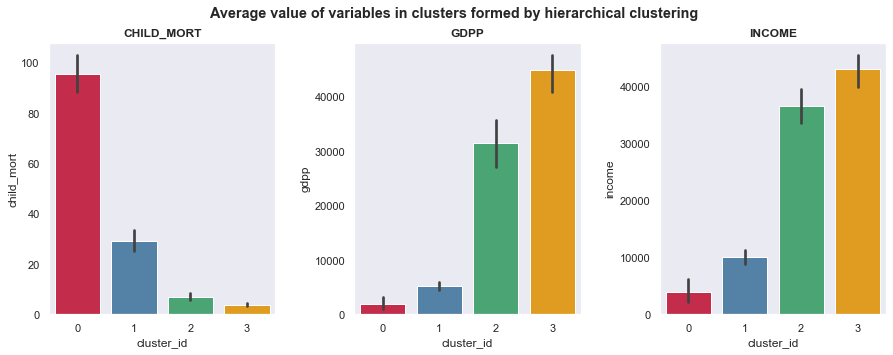

In [72]:
# Barplots to differentiate the clusters
cols = ['child_mort', 'gdpp', 'income']
plt.figure(figsize = (15,5))

for i,col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.barplot(y=col, x='cluster_id', data=df_hclusters, palette=pal)
    plt.title(col.upper(), weight='bold')

plt.suptitle('Average value of variables in clusters formed by hierarchical clustering', fontweight='bold')
plt.subplots_adjust(wspace=0.35, hspace = 0.15)

From the above plots, by analysing these 3 clusters we find that, 
- <b style='color:crimson;'>cluster_id = 0 - low income, low gdpp, high child_mort - Under-developed countries</b>
- <b style='color:steelblue;'>cluster_id = 1</b> - moderate income, moderate gdpp, moderate child_mort - Developing countries
- <b style='color:mediumseagreen;'>cluster_id = 2</b> - high income, high gdpp, low child_mort - Developed countries
- <b style='color:orange;'>cluster_id = 3</b> - high income, high gdpp, low child_mort - Highly Developed countries

#### Our target countries are present in the cluster with under-developed countries (<b style='color:crimson;'>cluster_id = 0</b>).

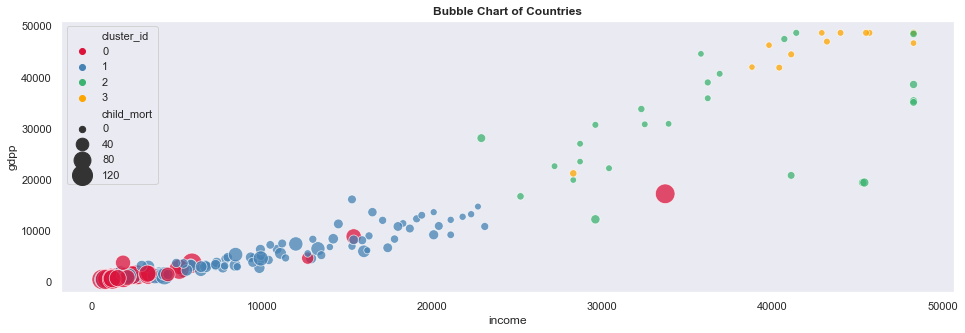

In [55]:
# Bubble chart to visualise all the 3 variables in a single chart
plt.figure(figsize=(16,5))
sns.scatterplot(x='income', y='gdpp', size='child_mort', data=df_hclusters, sizes=(40,400), hue='cluster_id', 
                alpha=0.75, palette=pal);
plt.title('Bubble Chart of Countries', fontweight='bold');

In the above plot,
- The <b style="color:crimson;">under-developed countries</b> are in the bottom-left part of the plot which are characterised generally by larger circles indicating they have higher child mortality rates as well.
- On the other hand, the developed countries are marked in the right-top part of the plot which are denoted by comparatively very small circles indicating the lower child mortality rate in those countries.

In [74]:
# Interactive bubble chart
source = df_hclusters
alt.Chart(source).mark_circle(size=60).encode(
    x='income', 
    y='gdpp', 
    size='child_mort', 
    color='cluster_id:N', 
    tooltip=['country']).properties(width=800, title='Interactive Bubble Chart of Countries').interactive()

alt.Chart(...)

From the above plots showing the clusters formed by hierarchical clustering, we can see that the cluster with **cluster_id=0** reperesents the under-developed countries. 

There are 33 countries in this cluster which are listed below:

In [57]:
target_hcluster = df_hclusters.loc[df_hclusters['cluster_id']==0]
target_hcluster

country  child_mort     exports   health     imports  \
0    Afghanistan              90.2000     55.3000     41.9174  248.2970      
3    Angola                   116.0000    2,199.1900  100.6050 1,514.3700    
17   Benin                    111.0000    180.4040    31.0780  281.9760      
25   Burkina Faso             116.0000    110.4000    38.7550  170.2000      
26   Burundi                  93.6000     20.6052     26.7960  90.5520       
28   Cameroon                 108.0000    290.8200    67.2030  353.7000      
31   Central African Republic 116.0000    52.6280     17.7508  118.1900      
32   Chad                     116.0000    330.0960    40.6341  390.1950      
37   Congo, Dem. Rep.         116.0000    137.2740    26.4194  165.6640      
38   Congo, Rep.              63.9000     2,331.7400  67.4040  1,498.7800    
40   Cote d'Ivoire            111.0000    617.3200    64.6600  528.2600      
49   Equatorial Guinea        111.0000    14,671.8000 766.0800 10,071.9000   
55   Gabon                    63.7000     5,048.7500  306.2500 1,653.7500    
59   Ghana                    74.7000     386.4500    68.3820  601.2900      
63   Guinea                   109.0000    196.3440    31.9464  279.9360      
64   Guinea-Bissau            114.0000    81.5030     46.4950  192.5440      
66   Haiti                    116.0000    101.2860    45.7442  428.3140      
72   Iraq                     36.9000     1,773.0000  378.4500 1,534.5000    
87   Lesotho                  99.7000     460.9800    129.8700 1,181.7000    
94   Malawi                   90.5000     104.6520    30.2481  160.1910      
97   Mali                     116.0000    161.4240    35.2584  248.5080      
99   Mauritania               97.4000     608.4000    52.9200  734.4000      
106  Mozambique               101.0000    131.9850    21.8299  193.5780      
112  Niger                    116.0000    77.2560     17.9568  170.8680      
113  Nigeria                  116.0000    589.4900    118.1310 405.4200      
132  Sierra Leone             116.0000    67.0320     52.2690  137.6550      
142  Sudan                    76.7000     291.5600    93.5360  254.5600      
147  Tanzania                 71.9000     131.2740    42.1902  204.2820      
149  Timor-Leste              62.6000     79.2000     328.3200 1,000.8000    
150  Togo                     90.3000     196.1760    37.3320  279.6240      
155  Uganda                   81.0000     101.7450    53.6095  170.1700      
165  Yemen                    56.3000     393.0000    67.8580  450.6400      
166  Zambia                   83.1000     540.2000    85.9940  451.1400      

         income  inflation  life_expec  total_fer        gdpp  cluster_id  
0   1,610.0000  9.4400     56.2000     5.8200     553.0000     0           
3   5,900.0000  20.8700    60.1000     5.8610     3,530.0000   0           
17  1,820.0000  0.8850     61.8000     5.3600     758.0000     0           
25  1,430.0000  6.8100     57.9000     5.8610     575.0000     0           
26  764.0000    12.3000    57.7000     5.8610     231.0000     0           
28  2,660.0000  1.9100     57.3000     5.1100     1,310.0000   0           
31  888.0000    2.0100     47.5000     5.2100     446.0000     0           
32  1,930.0000  6.3900     56.5000     5.8610     897.0000     0           
37  609.0000    20.8000    57.5000     5.8610     334.0000     0           
38  5,190.0000  20.7000    60.4000     4.9500     2,740.0000   0           
40  2,690.0000  5.3900     56.3000     5.2700     1,220.0000   0           
49  33,700.0000 20.8700    60.9000     5.2100     17,100.0000  0           
55  15,400.0000 16.6000    62.9000     4.0800     8,750.0000   0           
59  3,060.0000  16.6000    62.2000     4.2700     1,310.0000   0           
63  1,190.0000  16.1000    58.0000     5.3400     648.0000     0           
64  1,390.0000  2.9700     55.6000     5.0500     547.0000     0           
66  1,500.0000  5.4500     47.1600     3.3300     662.0000     0           
7

In [58]:
target_hcluster.describe()

child_mort     exports   health     imports      income  inflation  \
count 33.0000     33.0000     33.0000  33.0000     33.0000     33.0000      
mean  95.6818     985.4329    101.0271 792.9077    3,907.6667  11.7226      
std   22.0142     2,649.1208  148.1025 1,728.9525  6,223.0532  7.2322       
min   36.9000     20.6052     17.7508  90.5520     609.0000    0.8850       
25%   81.0000     101.7450    35.2584  192.5440    1,220.0000  5.3900       
50%   101.0000    196.1760    52.2690  281.9760    1,870.0000  12.1000      
75%   116.0000    540.2000    85.9940  601.2900    3,320.0000  18.9000      
max   116.0000    14,671.8000 766.0800 10,071.9000 33,700.0000 20.8700      

       life_expec  total_fer        gdpp  cluster_id  
count 33.0000     33.0000    33.0000     33.0000      
mean  58.5339     5.2045     1,902.3939  0.0000       
std   5.6980      0.6910     3,200.1303  0.0000       
min   47.1600     3.3000     231.0000    0.0000       
25%   56.2000     4.9500     547.0000    0.0000       
50%   58.0000     5.3100     758.0000    0.0000       
75%   60.9000     5.8610     1,460.0000  0.0000       
max   71.1000     5.8610     17,100.0000 0.0000

The current cluster consists of countries with a wide range of `gdpp`, `income` and `child_mort`. So, to narrow down our analysis to find the countries which are in direst need of aid, we'll take the countries which have less `gdpp` and `income` than the group median and high `child_mort` than the group median.

In [59]:
# Subsetting our final cluster
target_hcluster_final = target_hcluster.loc[(target_hcluster.gdpp < target_hcluster.gdpp.median()) & 
                                            (target_hcluster.income < target_hcluster.income.median()) & 
                                            (target_hcluster.child_mort > target_hcluster.child_mort.median())]
target_hcluster_final

country  child_mort  exports  health  imports  \
25   Burkina Faso             116.0000    110.4000 38.7550 170.2000   
31   Central African Republic 116.0000    52.6280  17.7508 118.1900   
37   Congo, Dem. Rep.         116.0000    137.2740 26.4194 165.6640   
63   Guinea                   109.0000    196.3440 31.9464 279.9360   
64   Guinea-Bissau            114.0000    81.5030  46.4950 192.5440   
66   Haiti                    116.0000    101.2860 45.7442 428.3140   
112  Niger                    116.0000    77.2560  17.9568 170.8680   
132  Sierra Leone             116.0000    67.0320  52.2690 137.6550   

        income  inflation  life_expec  total_fer     gdpp  cluster_id  
25  1,430.0000 6.8100     57.9000     5.8610     575.0000  0           
31  888.0000   2.0100     47.5000     5.2100     446.0000  0           
37  609.0000   20.8000    57.5000     5.8610     334.0000  0           
63  1,190.0000 16.1000    58.0000     5.3400     648.0000  0           
64  1,390.0000 2.9700     55.6000     5.0500     547.0000  0           
66  1,500.0000 5.4500     47.1600     3.3300     662.0000  0           
112 814.0000   2.5500     58.8000     5.8610     348.0000  0           
132 1,220.0000 17.2000    55.0000     5.2000     399.0000  0

In [60]:
target_hcluster_final.describe()

child_mort  exports  health  imports     income  inflation  life_expec  \
count 8.0000      8.0000   8.0000  8.0000   8.0000     8.0000     8.0000        
mean  114.8750    102.9654 34.6671 207.9214 1,130.1250 9.2363     54.6825       
std   2.4749      46.1386  13.2555 101.1125 324.2708   7.5656     4.7112        
min   109.0000    52.6280  17.7508 118.1900 609.0000   2.0100     47.1600       
25%   115.5000    74.7000  24.3038 158.6618 869.5000   2.8650     53.1250       
50%   116.0000    91.3945  35.3507 170.5340 1,205.0000 6.1300     56.5500       
75%   116.0000    117.1185 45.9319 214.3920 1,400.0000 16.3750    57.9250       
max   116.0000    196.3440 52.2690 428.3140 1,500.0000 20.8000    58.8000       

       total_fer     gdpp  cluster_id  
count 8.0000     8.0000   8.0000       
mean  5.2141     494.8750 0.0000       
std   0.8322     130.6844 0.0000       
min   3.3300     334.0000 0.0000       
25%   5.1625     386.2500 0.0000       
50%   5.2750     496.5000 0.0000       
75%   5.8610     593.2500 0.0000       
max   5.8610     662.0000 0.0000

There are 8 countries falling under our consideration.

In [61]:
print('The list of countries identified by kmeans clustering:',*sorted(list(target_hcluster_final.country)), sep='\n')

The list of countries identified by kmeans clustering:
Burkina Faso
Central African Republic
Congo, Dem. Rep.
Guinea
Guinea-Bissau
Haiti
Niger
Sierra Leone


We'll merge the results from both the methods.

In [62]:
target_countries = sorted(list(set(target_cluster_final.country).union(set(target_hcluster_final.country))))
print('The final list of countries by combining both the lists:',*sorted(list(target_countries)), sep='\n')

The final list of countries by combining both the lists:
Afghanistan
Benin
Burkina Faso
Burundi
Central African Republic
Congo, Dem. Rep.
Guinea
Guinea-Bissau
Haiti
Malawi
Mozambique
Niger
Sierra Leone
Togo


Looks like the countries identified by hierarchical clustering is a subset of the countries identified by k-means clustering, hence we'll proceed with `target_countries` to visualise how it performs in various parameters.

## Final Analysis

We'll load the original data again as we have as we have modified some of the values while treating the outliers and we have finalised our target cluster.

In [63]:
# loading the original data for visualisation
countries = pd.read_csv('Country-data.csv')

final_df = countries.loc[countries.country.isin(target_countries)]
final_df.sort_values(by=['gdpp','child_mort','income'], ascending=[True,False,True],inplace=True)
final_df

country  child_mort  exports  health  imports  income  \
26   Burundi                  93.6000     8.9200   11.6000 39.2000   764      
37   Congo, Dem. Rep.         116.0000    41.1000  7.9100  49.6000   609      
112  Niger                    123.0000    22.2000  5.1600  49.1000   814      
132  Sierra Leone             160.0000    16.8000  13.1000 34.5000   1220     
106  Mozambique               101.0000    31.5000  5.2100  46.2000   918      
31   Central African Republic 149.0000    11.8000  3.9800  26.5000   888      
94   Malawi                   90.5000     22.8000  6.5900  34.9000   1030     
150  Togo                     90.3000     40.2000  7.6500  57.3000   1210     
64   Guinea-Bissau            114.0000    14.9000  8.5000  35.2000   1390     
0    Afghanistan              90.2000     10.0000  7.5800  44.9000   1610     
25   Burkina Faso             116.0000    19.2000  6.7400  29.6000   1430     
63   Guinea                   109.0000    30.3000  4.9300  43.2000   1190     
66   Haiti                    208.0000    15.3000  6.9100  64.7000   1500     
17   Benin                    111.0000    23.8000  4.1000  37.2000   1820     

     inflation  life_expec  total_fer  gdpp  
26  12.3000    57.7000     6.2600      231   
37  20.8000    57.5000     6.5400      334   
112 2.5500     58.8000     7.4900      348   
132 17.2000    55.0000     5.2000      399   
106 7.6400     54.5000     5.5600      419   
31  2.0100     47.5000     5.2100      446   
94  12.1000    53.1000     5.3100      459   
150 1.1800     58.7000     4.8700      488   
64  2.9700     55.6000     5.0500      547   
0   9.4400     56.2000     5.8200      553   
25  6.8100     57.9000     5.8700      575   
63  16.1000    58.0000     5.3400      648   
66  5.4500     32.1000     3.3300      662   
17  0.8850     61.8000     5.3600      758

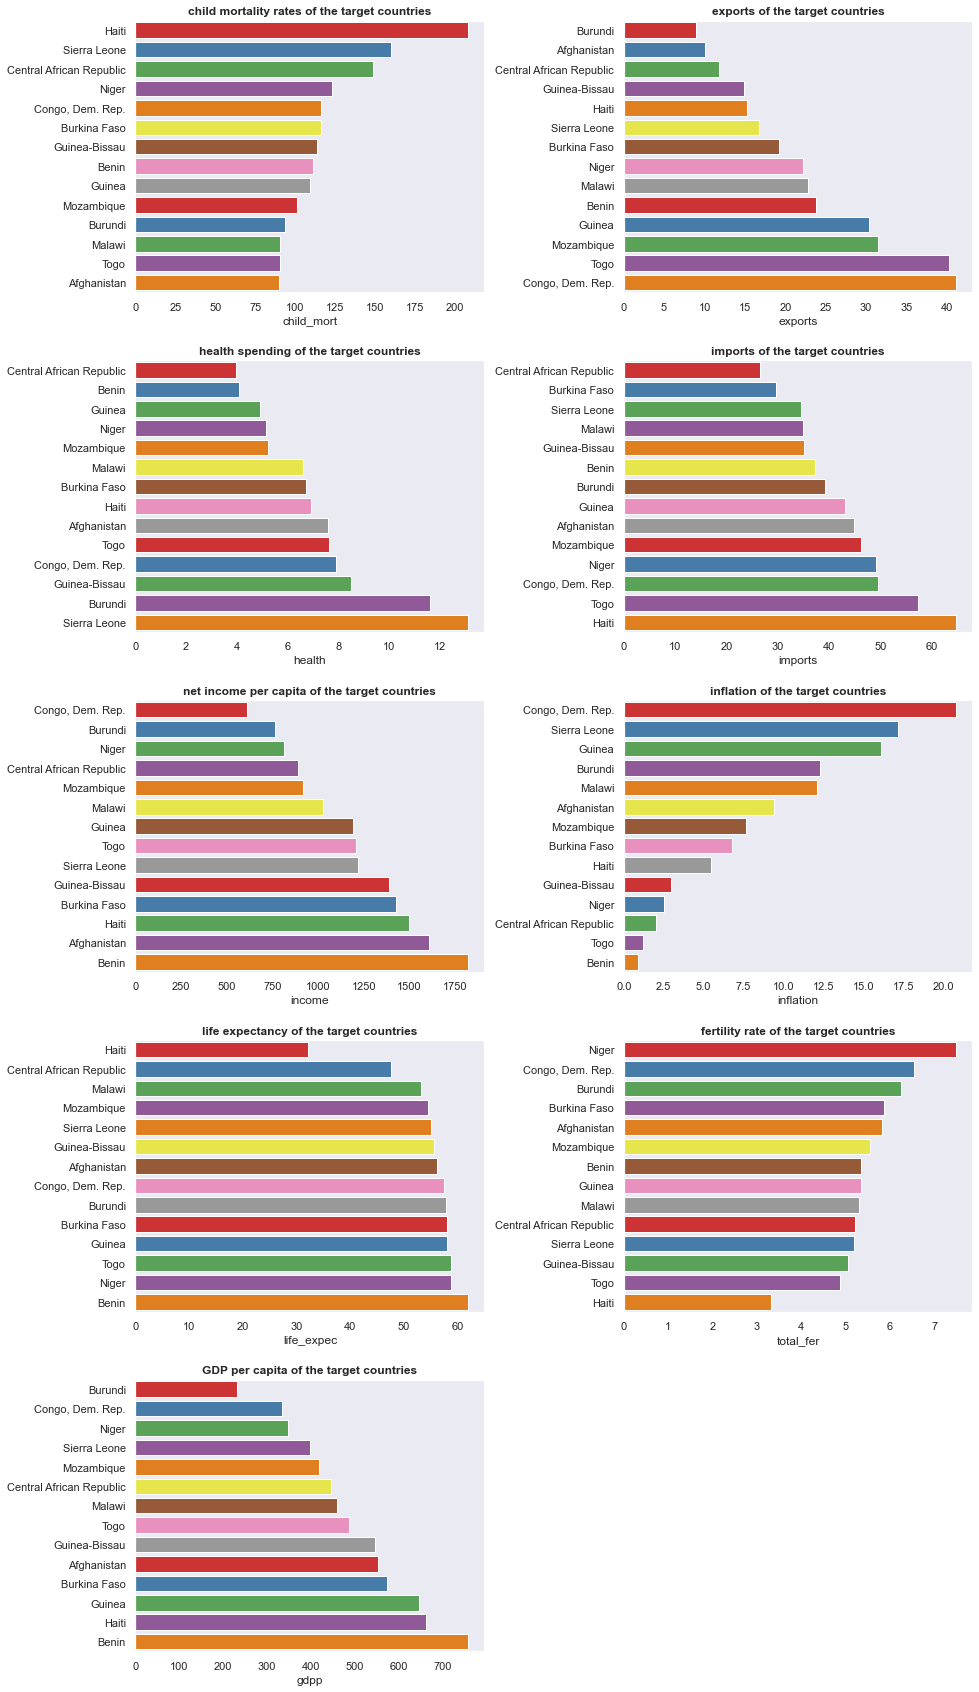

In [64]:
# Plotting barplots to compare the performance of countries in each category
cols = final_df.select_dtypes(exclude='object').columns
col_names = ['child mortality rates', 'exports', 'health spending', 'imports', 'net income per capita',
            'inflation', 'life expectancy', 'fertility rate', 'GDP per capita']
plt.figure(figsize = (15,30))

for i,col in enumerate(cols):
    plt.subplot(5, 2, i+1)
    if col in ['child_mort', 'inflation', 'total_fer']:
        sns.barplot(data=final_df.nlargest(14, col), x=col, y='country', palette='Set1')
        plt.title('%s of the target countries' %(col_names[i]), fontweight='bold')
        plt.ylabel(None);
    else:    
        sns.barplot(data=final_df.nsmallest(14, col), x=col, y='country', palette='Set1')
        plt.title('%s of the target countries' %(col_names[i]), fontweight='bold')
        plt.ylabel(None);

plt.subplots_adjust(wspace=0.4, hspace = 0.25)

#### Inferences from above plots:
- Haiti performs the worst in case of child mortality rates and life expectancy despite having higher GDP per capita and net income per capita than most of the countries in this list.
- Burundi is the country with the lowest per capita GDP and one of the lowest net income per capita.
- 12/14 countries are from Africa, 1 from Asia and 1 from North America.

In [65]:
# Choropleth that shows the target countries in the world map
fig = go.Figure(data=go.Choropleth(locations = final_df['country'], locationmode = 'country names',
                                   z = final_df['child_mort'], colorscale = 'Reds', 
                                   marker_line_color = 'black', marker_line_width = 0.5))

fig.update_layout(title_text = 'Child Mortality in Target Countries', title_x = 0.5, 
                  geo=dict(showframe = False, showcoastlines = False, projection_type = 'equirectangular'))

In [66]:
# Choropleth that shows the target countries in the world map
fig = go.Figure(data=go.Choropleth(locations = final_df['country'], locationmode = 'country names',
                                   z = final_df['gdpp'], colorscale = 'Blues', 
                                   marker_line_color = 'black', marker_line_width = 0.5))

fig.update_layout(title_text = 'GDPP of Target Countries', title_x = 0.5, 
                  geo=dict(showframe = False, showcoastlines = False, projection_type = 'equirectangular'))

In [67]:
# Choropleth that shows the target countries in the world map
fig = go.Figure(data=go.Choropleth(locations=final_df['country'], locationmode='country names',
                                   z=final_df['income'], colorscale='Greens', 
                                   marker_line_color='black', marker_line_width=0.5))

fig.update_layout(title_text='Income of Target Countries', title_x=0.5, 
                  geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'))

In [68]:
# Final list of countries - 14 countries
print('The final list of recommended countries:')
(final_df.reset_index(drop=True).country.sort_values()).reset_index(drop=True)

The final list of recommended countries:


0     Afghanistan             
1     Benin                   
2     Burkina Faso            
3     Burundi                 
4     Central African Republic
5     Congo, Dem. Rep.        
6     Guinea                  
7     Guinea-Bissau           
8     Haiti                   
9     Malawi                  
10    Mozambique              
11    Niger                   
12    Sierra Leone            
13    Togo                    
Name: country, dtype: object